# Credit Risk Assessment

# 1. Project Overview

**Context**

The consumer credit department of a bank wants to automate the decisionmaking process for approval of home equity lines of credit. To do this, they will follow the recommendations of the Equal Credit Opportunity Act to create an empirically derived and statistically sound credit scoring model. The model will be based on data collected from recent applicants granted credit through the current process of loan underwriting. The model will be built from predictive modeling tools, but the created model must be sufficiently interpretable to provide a reason for any adverse actions (rejections).

**Content**

The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable indicating whether an applicant eventually defaulted or was seriously delinquent. This adverse outcome occurred in 1,189 cases (20%). For each applicant, 12 input variables were recorded.

**Data source**: https://www.kaggle.com/datasets/ajay1735/hmeq-data


## 2. Imports

In [103]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 3. Data Loading

In [104]:
credit = pd.read_csv('./datasets/hmeq.csv')
credit.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


## 4. Data Inspection

In [105]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


**Observations**:

- The dataset has 5960 entries with 13 columns.
- There are missing values in several columns, notably in MORTDUE, DEBTINC, and others.
- The data types are appropriate, with numerical columns as floats and categorical columns as objects.

## 5. Data Cleaning

### Handling Duplicates

In [106]:
# Check for duplicate rows
duplicates = credit.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicates.sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


### Handling Missing Values

Handling rows with missing entries of more than 50%

In [107]:
# Calculate the threshold for 50% missing values
threshold = credit.shape[1] / 2

# Identify rows with more than 50% missing values
rows_with_many_missing = credit.isna().sum(axis=1) > threshold

# Count the number of rows with more than 50% missing values
num_rows_with_many_missing = rows_with_many_missing.sum()

print(f"Number of rows with more than 50% missing values: {num_rows_with_many_missing}")

# Remove these rows
credit = credit[~rows_with_many_missing]

# Verify the removal
print(f"Number of rows after removal: {credit.shape[0]}")

Number of rows with more than 50% missing values: 126
Number of rows after removal: 5834


#### Missing values per column

In [108]:
# Missing values per column by percentage
(credit.isna().mean() * 100).sort_values()

BAD         0.000000
LOAN        0.000000
VALUE       1.628385
CLNO        1.645526
REASON      2.862530
JOB         2.982516
CLAGE       3.119643
NINQ        6.582105
YOJ         6.993486
MORTDUE     7.559136
DELINQ      7.781968
DEROG       9.976003
DEBTINC    21.049023
dtype: float64

### Imputation

**For Numerical Features**:

**Median Imputation**: For features like MORTDUE, VALUE, and DEBTINC, median imputation is simple, interpretable, and reduces the risk of bias from outliers.


**For Categorical Features**:

**Mode Imputation**: For categorical features like REASON and JOB, mode imputation is standard and straightforward.

In [109]:
# Median Imputation for Numerical Features
numerical_cols = ['VALUE', 'CLNO', 'CLAGE', 'NINQ', 'YOJ', 'MORTDUE', 'DELINQ', 'DEROG', 'DEBTINC']
for col in numerical_cols:
    credit[col] = credit[col].fillna(credit[col].median())

# Mode Imputation for Categorical Features
categorical_cols = ['REASON', 'JOB']
for col in categorical_cols:
    credit[col] = credit[col].fillna(credit[col].mode()[0])
    
# New amount of missing values per column by percentage
(credit.isna().mean() * 100).sort_values()

BAD        0.0
LOAN       0.0
MORTDUE    0.0
VALUE      0.0
REASON     0.0
JOB        0.0
YOJ        0.0
DEROG      0.0
DELINQ     0.0
CLAGE      0.0
NINQ       0.0
CLNO       0.0
DEBTINC    0.0
dtype: float64

## 6. Exploratory Data Analysis (EDA)

**Objective**:

Understand the distribution and relationships within the data.
Identify patterns and insights that can inform the modeling process.

### Target Variable Distribution

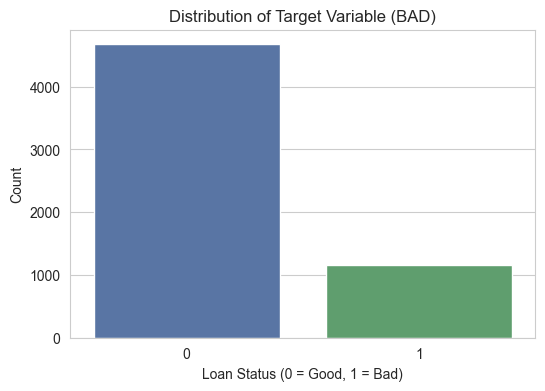

In [110]:
# Set plot style
sns.set_style('whitegrid')

# Plot the distribution of the target variable 'BAD'
plt.figure(figsize=(6,4))
sns.countplot(x='BAD', data=credit, palette=['#4c72b0','#55a868'])
plt.title('Distribution of Target Variable (BAD)')
plt.xlabel('Loan Status (0 = Good, 1 = Bad)')
plt.ylabel('Count')
plt.show()

**Observation**:

- The dataset is imbalanced with approximately 20% of loans classified as 'Bad' and 80% as 'Good'.
- This imbalance should be addressed during modeling, possibly through techniques like class weighting or resampling.

### Numerical Feature Distributions

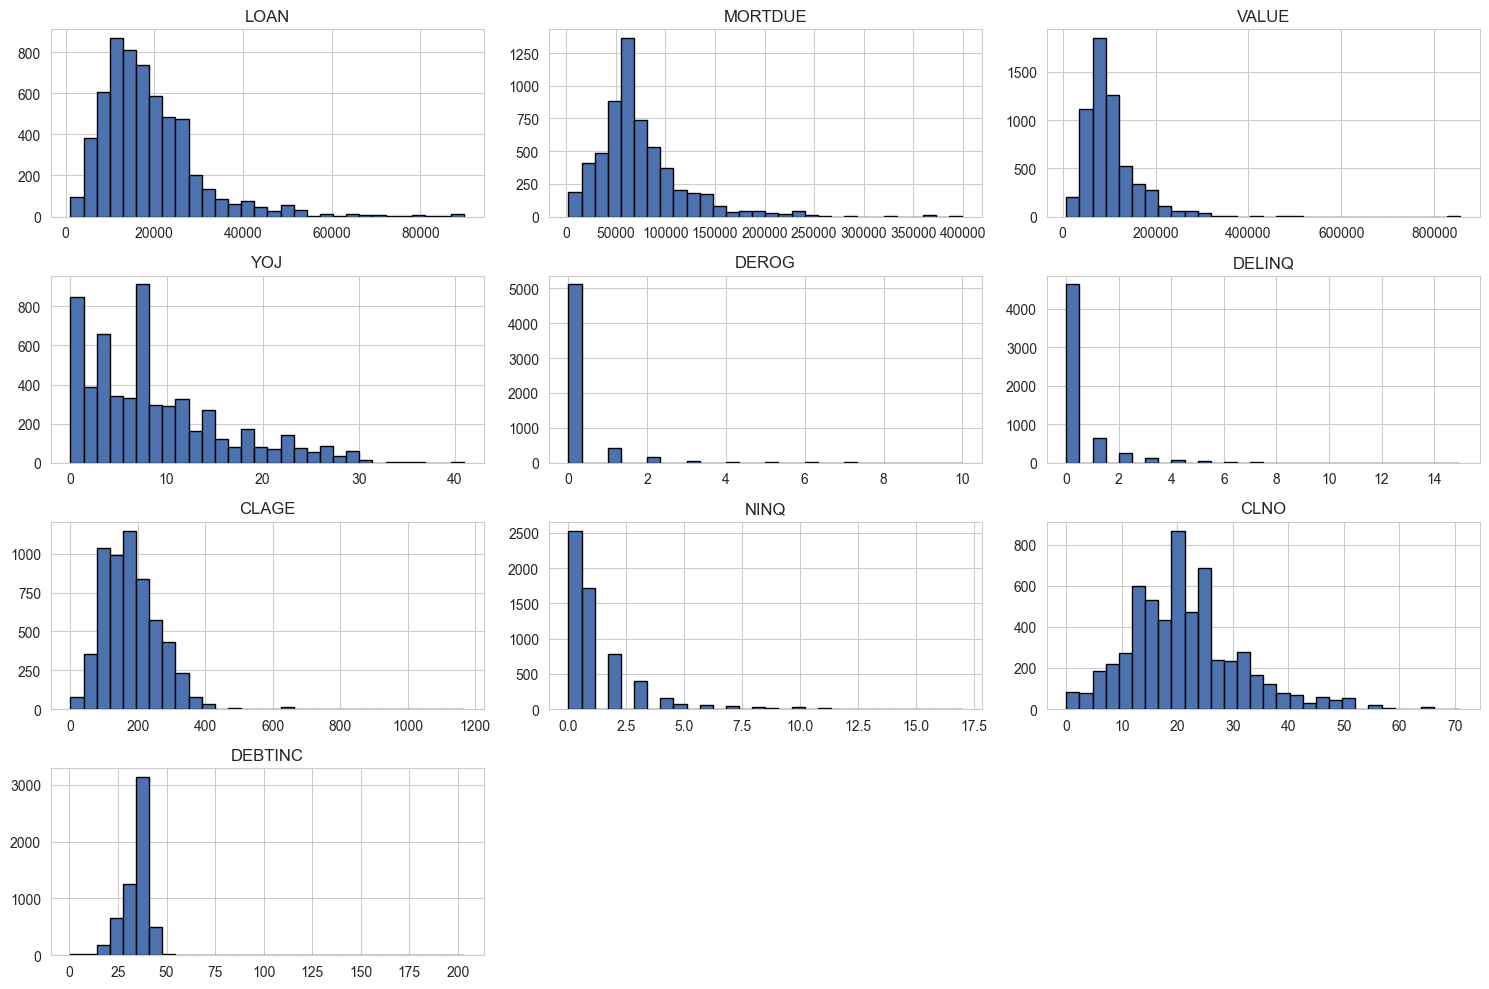

In [111]:
# Histograms for numerical features
numerical_features = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

credit[numerical_features].hist(bins=30, figsize=(15, 10), color='#4c72b0', edgecolor='black')
plt.tight_layout()
plt.show()

**Observation**:

- Many features are right-skewed (e.g., LOAN, MORTDUE, VALUE, DEBTINC).
- Some features have a significant number of zeros (e.g., YOJ, NINQ, DEROG, DELINQ).

### Categorical Features Distribution

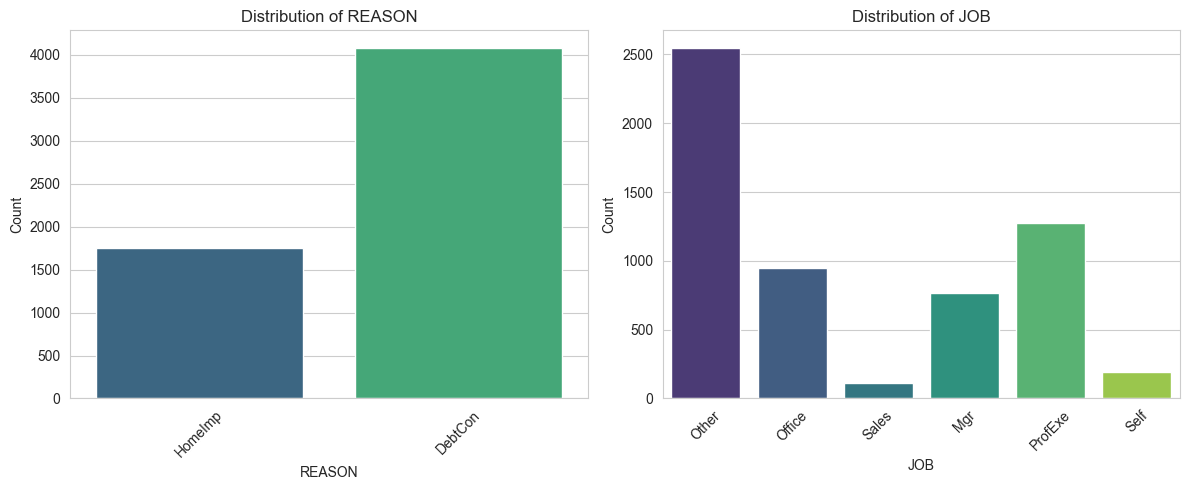

In [112]:
# Bar plots for categorical features
categorical_features = ['REASON', 'JOB']

plt.figure(figsize=(12, 5))

for i, col in enumerate(categorical_features):
    plt.subplot(1, 2, i+1)
    sns.countplot(x=col, data=credit, palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Observation**:

- REASON: Majority of the loans are for 'DebtCon' (Debt Consolidation) compared to 'HomeImp' (Home Improvement).
- JOB: 'ProfExe', and 'Office' are the most common job categories while combination of all other job types apart from the categories stated constitute the highest contribution to the dataset

### Correlation Matrix

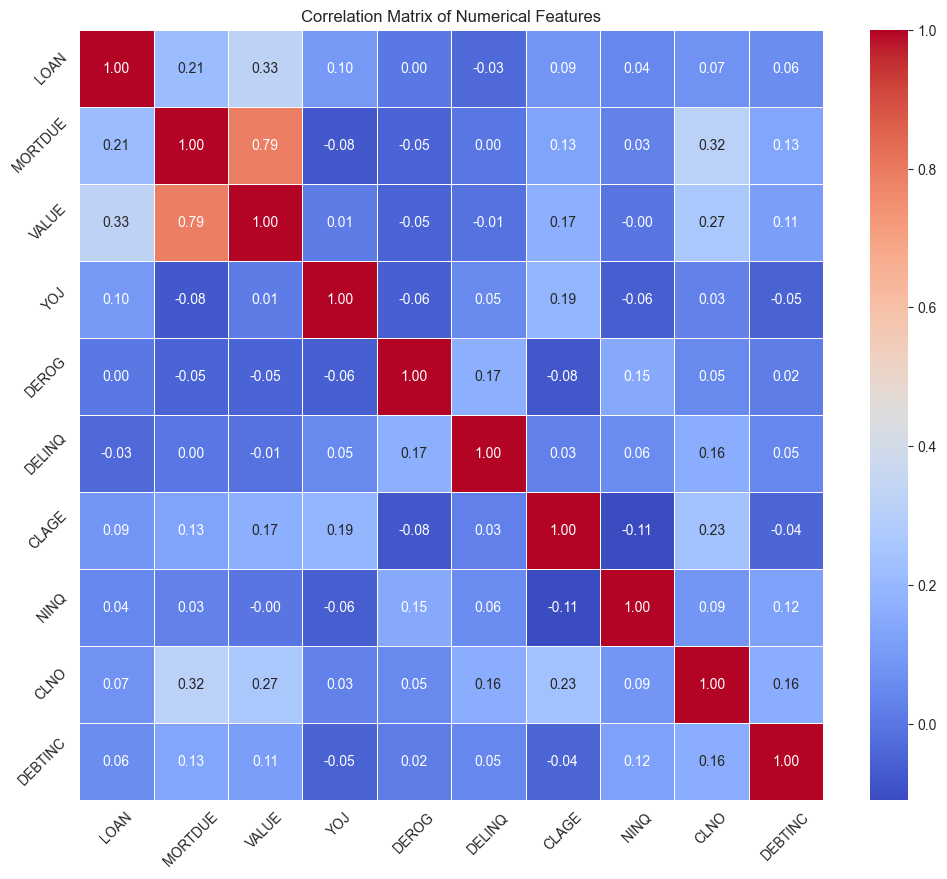

In [113]:
# Compute correlation matrix
corr_matrix = credit[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

**Observation**:

- Strong positive correlations between MORTDUE and VALUE (0.97) indicates that higher mortgage due amounts are associated with higher property values.

- Weak correlations between other variables and BAD.

### Relationship between Features and Target

Numerical Features

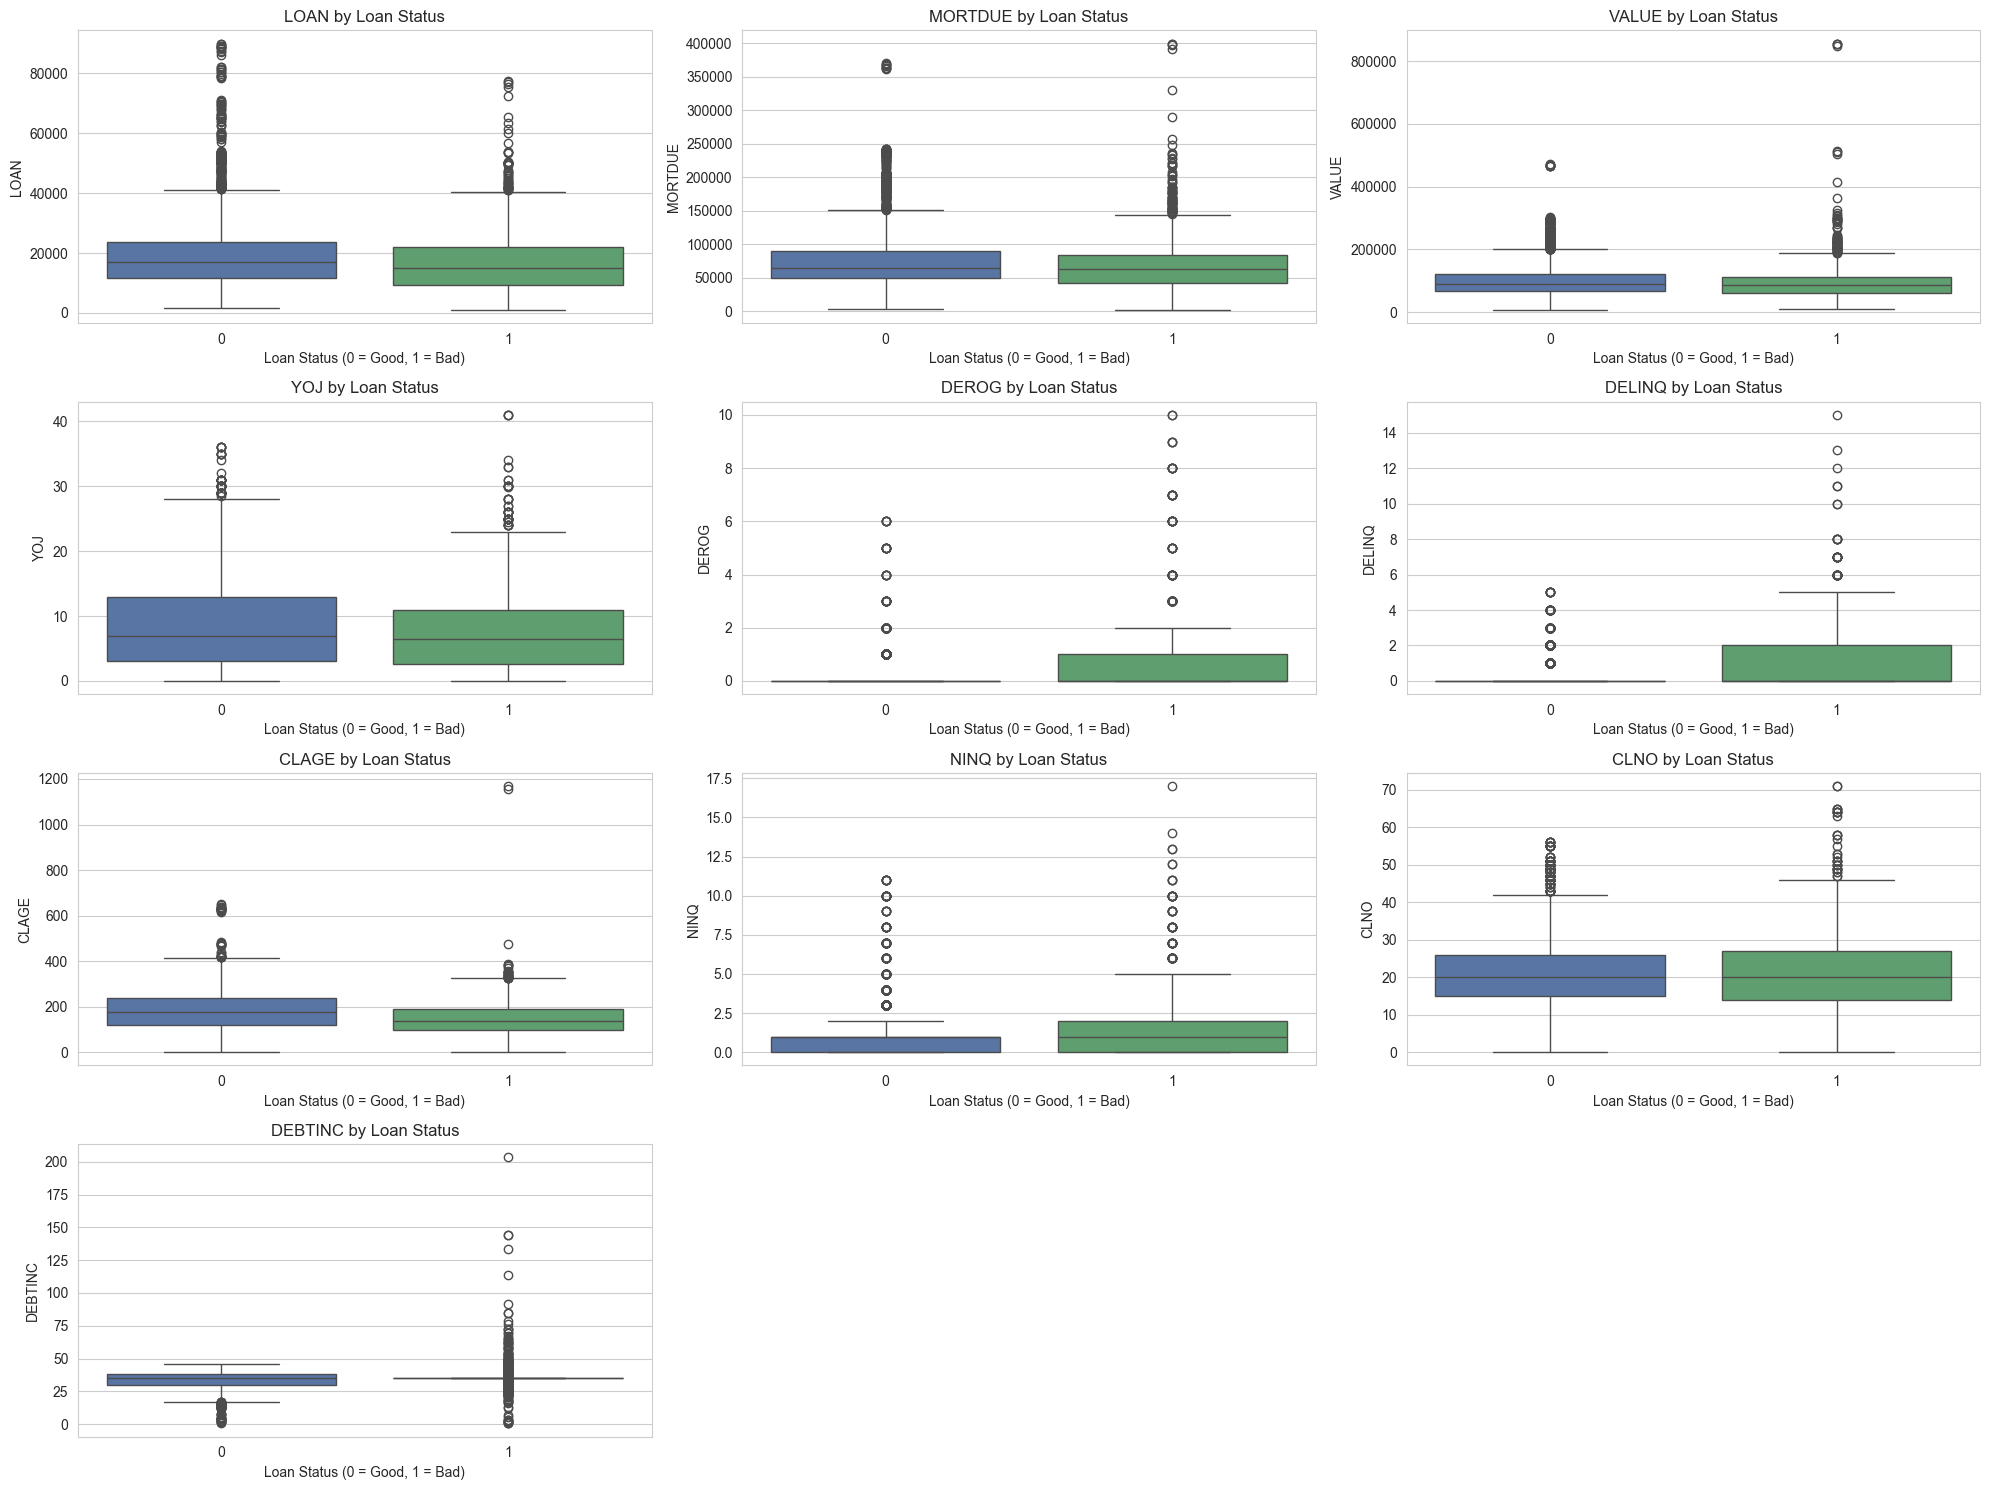

In [114]:
# Boxplots of numerical features against target variable
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='BAD', y=col, data=credit, palette=['#4c72b0','#55a868'])
    plt.title(f'{col} by Loan Status')
    plt.xlabel('Loan Status (0 = Good, 1 = Bad)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

Observation:

- Applicants with higher DEBTINC tend to have a higher proportion of 'Bad' loans.
- Higher DEROG and DELINQ counts are associated with 'Bad' loans.
- These features look to be important predictors and should be emphasized in the model.

Categorical Features

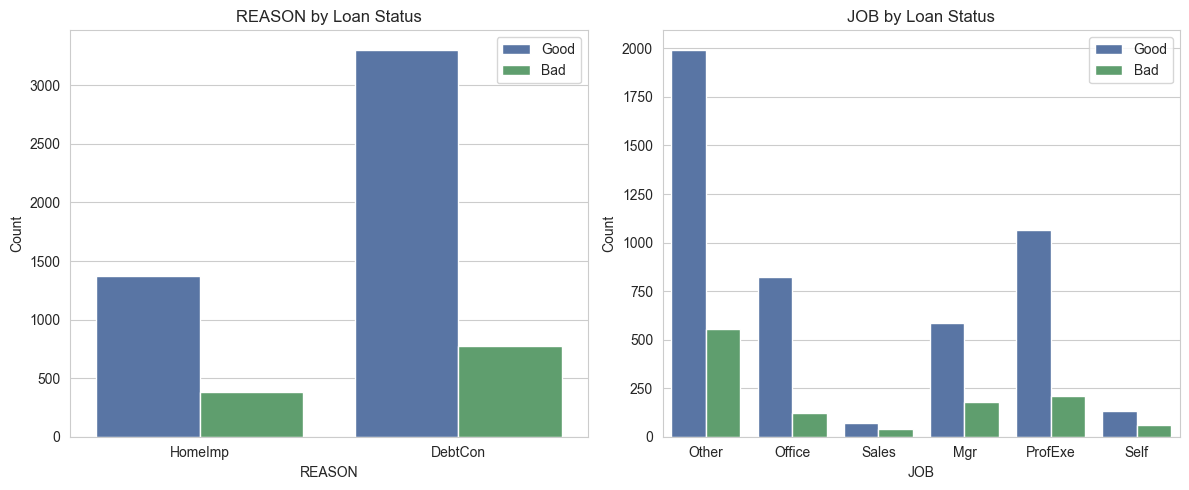

In [115]:
# Bar plots of categorical features against target variable
plt.figure(figsize=(12, 5))

for i, col in enumerate(categorical_features):
    plt.subplot(1, 2, i+1)
    sns.countplot(x=col, hue='BAD', data=credit, palette=['#4c72b0','#55a868'])
    plt.title(f'{col} by Loan Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(['Good', 'Bad'])

plt.tight_layout()
plt.show()

Observation:

- REASON: Slightly higher proportion of 'Bad' loans for 'DebtCon' compared to 'HomeImp'.

- JOB: Some job categories like 'Other' and 'Sales' have higher proportions of 'Bad' loans.

- Categorical variables have predictive power and should be included in the model.

## 7. Data Preprocessing

### Encoding

In [116]:
# One-hot encode 'REASON' and 'JOB'
credit_encoded = pd.get_dummies(credit, columns=['REASON', 'JOB'], drop_first=True)

### Feature Scaling

In [117]:
# Initialize scaler
scaler = StandardScaler()

# Identify features to scale (all except target variable 'BAD')
features_to_scale = credit_encoded.drop('BAD', axis=1).columns

# Fit and transform the data
credit_encoded[features_to_scale] = scaler.fit_transform(credit_encoded[features_to_scale])

## Modeling and Evaluation

### Pre-modeling

In [118]:
# Define feature matrix X and target vector y
X = credit_encoded.drop('BAD', axis=1)
y = credit_encoded['BAD']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 4667 samples
Testing set size: 1167 samples


### Modeling

#### Logistic Regression

In [119]:
# Initialize logistic regression model with class weight to handle imbalance
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# Fit the model
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

#### Decision Tree Classifier

In [120]:
# Initialize decision tree classifier with class weight
dt_clf = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

# Fit the model
dt_clf.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_clf.predict(X_test)
y_proba_dt = dt_clf.predict_proba(X_test)[:, 1]

#### Random Forest Classifier

In [121]:
# Initialize random forest classifier with class weight
rf_clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Fit the model
rf_clf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

### Evaluation

#### Logistic Regression

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       935
           1       0.45      0.63      0.52       232

    accuracy                           0.77      1167
   macro avg       0.67      0.72      0.69      1167
weighted avg       0.81      0.77      0.79      1167



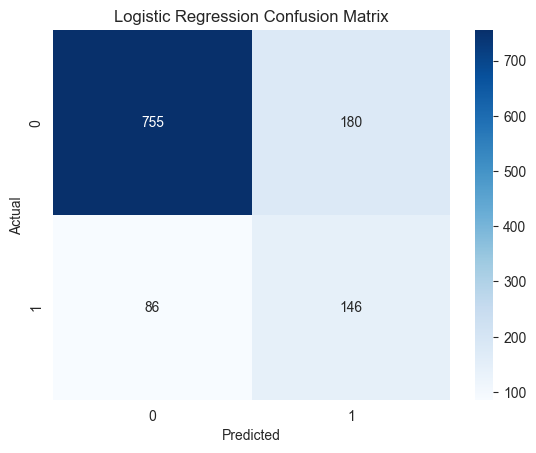

Logistic Regression ROC-AUC Score: 0.7996


In [122]:
# Classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC score
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"Logistic Regression ROC-AUC Score: {roc_auc_lr:.4f}")

#### Decision Tree Classifier

Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       935
           1       0.66      0.72      0.69       232

    accuracy                           0.87      1167
   macro avg       0.79      0.82      0.80      1167
weighted avg       0.88      0.87      0.87      1167



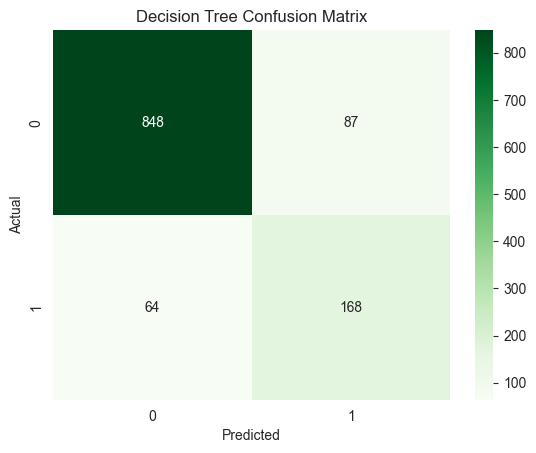

Decision Tree ROC-AUC Score: 0.8639


In [123]:
# Classification report
print("Decision Tree Classification Report:\n")
print(classification_report(y_test, y_pred_dt))

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC score
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print(f"Decision Tree ROC-AUC Score: {roc_auc_dt:.4f}")

#### Random Forest Classifier

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       935
           1       0.85      0.64      0.73       232

    accuracy                           0.90      1167
   macro avg       0.88      0.80      0.83      1167
weighted avg       0.90      0.90      0.90      1167



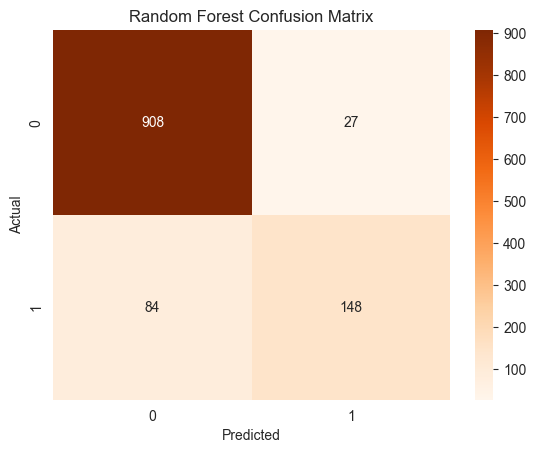

Random Forest ROC-AUC Score: 0.9574


In [124]:
# Classification report
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC score
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Random Forest ROC-AUC Score: {roc_auc_rf:.4f}")

### Performance

In [125]:
# Compile metrics into a dataframe
metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf)
    ],
    'ROC-AUC': [
        roc_auc_lr,
        roc_auc_dt,
        roc_auc_rf
    ]
})

# Display the metrics
metrics.set_index('Model', inplace=True)
metrics.style.background_gradient(cmap='Blues', subset=['Accuracy','Precision','Recall','F1-Score','ROC-AUC'])

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
Logistic Regression,0.772065,0.447853,0.629310,0.523297,0.799604
Decision Tree,0.870608,0.658824,0.724138,0.689938,0.863908
Random Forest,0.904884,0.845714,0.637931,0.727273,0.957450


From the look of things:

- Logistic Regression: Offers good interpretability with decent performance metrics.
- Decision Tree: Provides clear decision rules, slightly lower performance compared to logistic regression.
- Random Forest: Higher performance metrics but less interpretable.

### ROC Curves Comparison

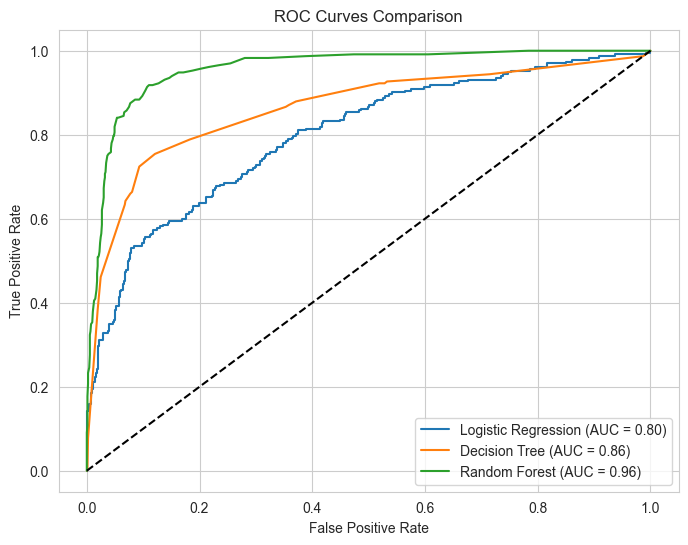

In [126]:
# Plot ROC curves
plt.figure(figsize=(8,6))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Plot settings
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()

**Observation**:

- Random Forest has the highest AUC, indicating better discriminatory ability.

- Logistic Regression performs reasonably well and is more interpretable.

- Decision should balance between performance and interpretability based on business needs.

## 9. Model Interpretation

### Logistic Regression Coefficients

In [127]:
# Extract coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})

# Calculate absolute values for sorting
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()

# Sort by absolute coefficient value
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10 features
coefficients.head(10)

,Feature,Coefficient,Abs_Coefficient
5,DELINQ,0.900983,0.900983
4,DEROG,0.540735,0.540735
9,DEBTINC,0.516945,0.516945
6,CLAGE,-0.455402,0.455402
7,NINQ,0.273343,0.273343
11,JOB_Office,-0.218143,0.218143
0,LOAN,-0.215944,0.215944
8,CLNO,-0.203058,0.203058
14,JOB_Sales,0.178239,0.178239
2,VALUE,0.162422,0.162422


**Interpretation**:

- Positive coefficients indicate that as the feature increases, the likelihood of default ('Bad') increases.

- Negative coefficients indicate that as the feature increases, the likelihood of default decreases.

- Top Influential Features could be DEBTINC, DEROG, DELINQ, etc.

### Decision Tree Visualization

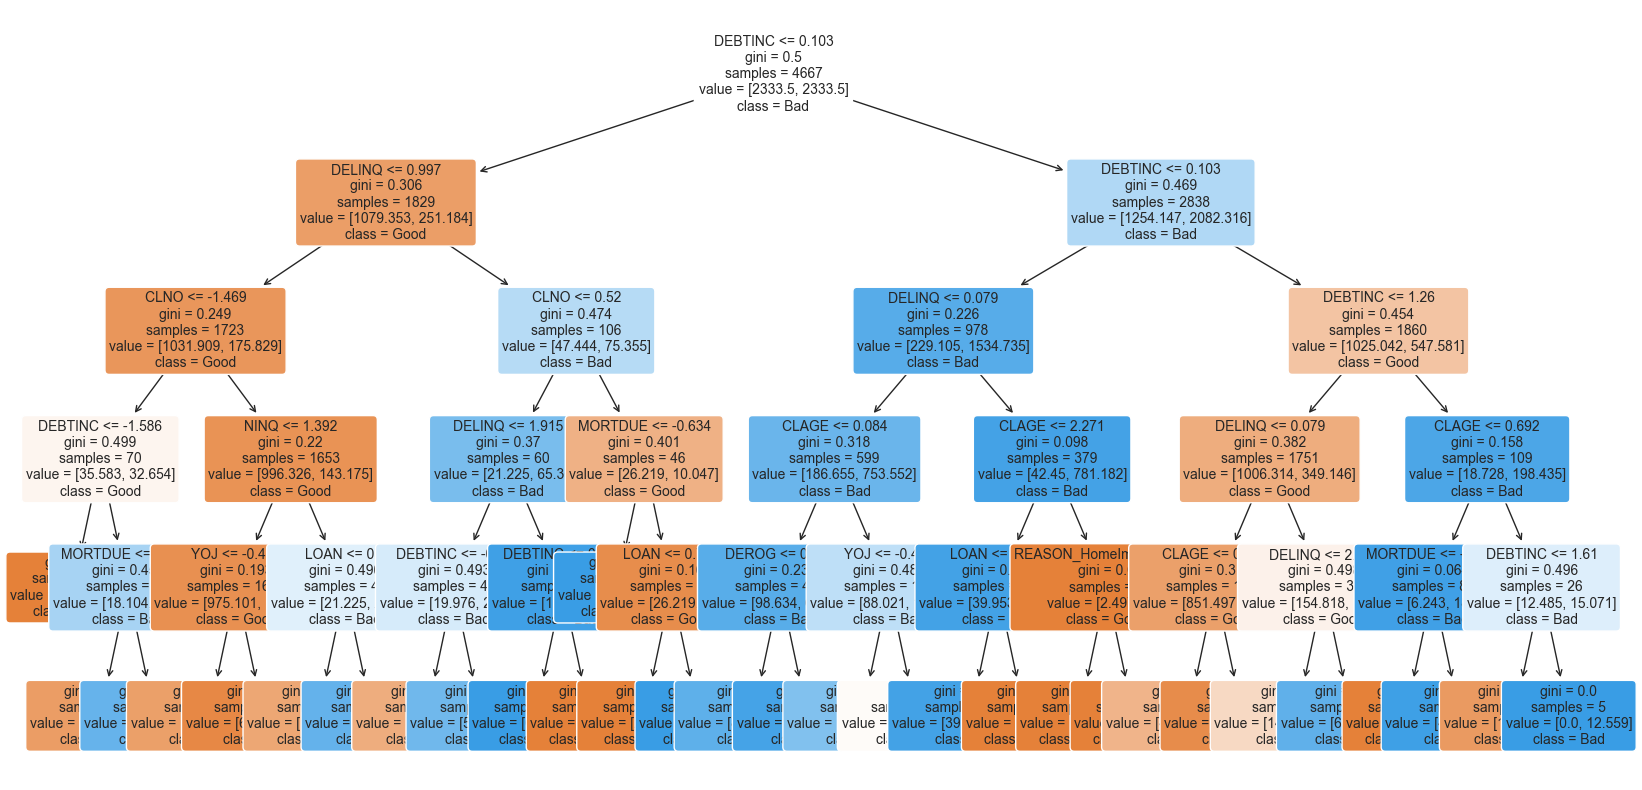

In [128]:
# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_clf, feature_names=X.columns, class_names=['Good', 'Bad'], filled=True, rounded=True, fontsize=10)
plt.show()

### Feature Importance in Random Forest

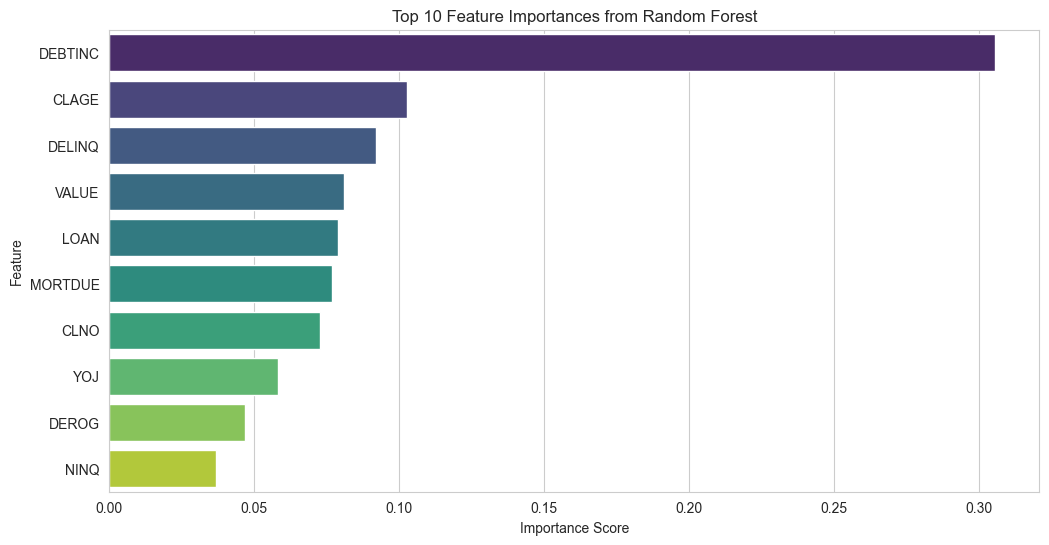

In [129]:
# Extract feature importances
importances = rf_clf.feature_importances_

# Create a dataframe
feat_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Consistent Important Features: 

Features like DEBTINC, DEROG, and DELINQ consistently appear important across models.

## 10. Conclusions

**Data Quality**: 

The dataset was cleaned effectively, handling missing values through appropriate imputation methods.

**EDA Findings**:

Certain features like DEBTINC, DEROG, and DELINQ are strong indicators of credit risk.
The dataset exhibited class imbalance which was addressed during modeling.

**Model Performance**:

Logistic Regression provided a good balance between interpretability and performance.
Decision Tree offered clear and understandable decision rules but slightly lower performance.
Random Forest achieved the highest performance metrics but at the cost of reduced interpretability.

**Interpretability**:

Given regulatory requirements, Logistic Regression and Decision Tree models are preferable due to their transparency.
Feature importance analysis helps in explaining model decisions, critical for compliance and customer communication.

## 11. Summary

This project successfully developed and evaluated models to automate credit risk assessment for home equity lines of credit. Through thorough data cleaning, exploratory analysis, and modeling, we identified key predictors of credit default and built interpretable models compliant with regulatory requirements. Future work includes refining models through hyperparameter tuning, incorporating additional data sources, and establishing robust monitoring systems to maintain model effectiveness over time.